# Import các thư viện cần thiết

In [55]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skimage.feature import hog

import PIL
from PIL import Image
import cv2
import pickle


# Import Dataset

In [57]:
danger_paths = glob("/content/drive/MyDrive/FinalProject_CS231/data/danger"+"/*")[:150]
notify_paths = glob("/content/drive/MyDrive/FinalProject_CS231/data/instruction"+"/*")[:150]
prohi_paths = glob("/content/drive/MyDrive/FinalProject_CS231/data/prohibition"+"/*")[:150]
neg_paths = glob("/content/drive/MyDrive/FinalProject_CS231/data/neg"+"/*")[:150]

print("There are {} danger images in the dataset".format(len(danger_paths)))
print("There are {} notify images in the dataset".format(len(notify_paths)))
print("There are {} prohibition images in the dataset".format(len(prohi_paths)))
print("There are {} negative images in the dataset".format(len(neg_paths)))

There are 150 danger images in the dataset
There are 150 notify images in the dataset
There are 150 prohibition images in the dataset
There are 150 negative images in the dataset


# Sample

In [60]:
def show(items: list, nrows=1, ncols=1, figsize: tuple[int, int] = None, random=False) -> None:
    fig = plt.gcf()
    if figsize is None:
        fig.set_size_inches(ncols * 3, nrows * 3)
    else:
        fig.set_size_inches(figsize[0], figsize[1])

    if random:
        random.shuffle(items)

    for i, item in enumerate(items[: nrows * ncols]):
        plt.subplot(nrows, ncols, i + 1)

        ax = plt.gca()
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        image = plt.imread(item) if type(item) is str else item
        plt.imshow(image, cmap = None if image.ndim != 2 else 'gray')

    plt.show()

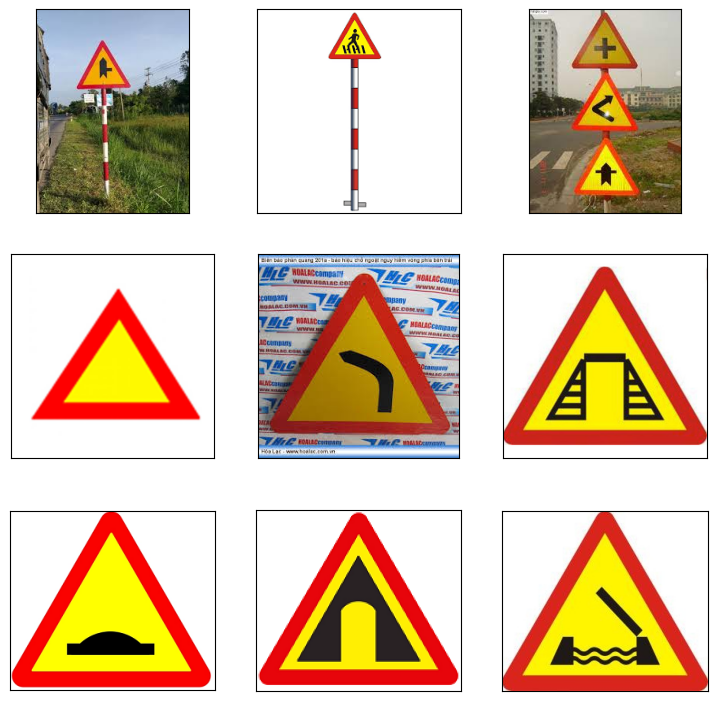

In [61]:
show(danger_paths, 3, 3)

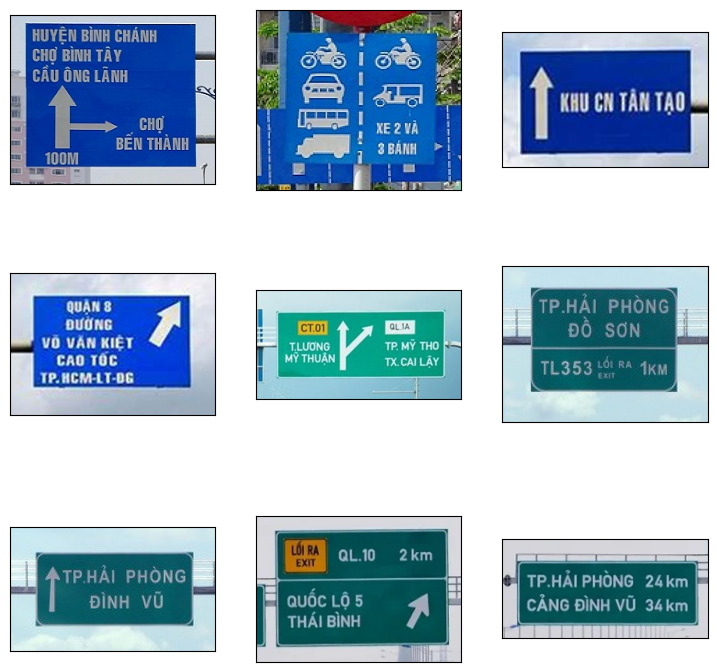

In [62]:
show(neg_paths, 3, 3)

Shape of image: (83, 88, 3)


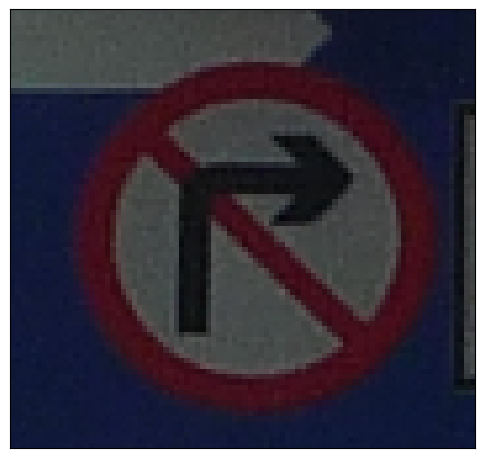

In [63]:
example_image = np.asarray(PIL.Image.open(prohi_paths[55]))

print("Shape of image:", example_image.shape)
show([example_image], figsize=(6,6))

In [64]:
# Some constants
PIXELS_PER_CELL = (8, 8)


The number of HOG features: (3240,)


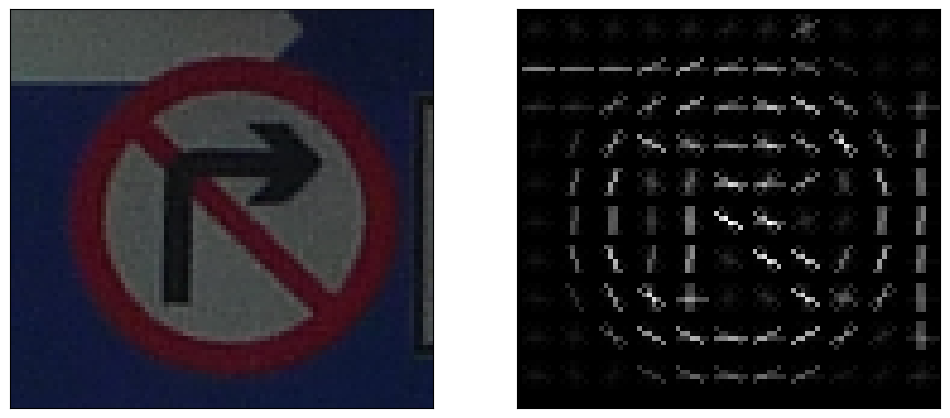

In [65]:
from skimage.feature import hog

hog_features, visualized = hog(image=example_image,
                              orientations=9,
                              pixels_per_cell=PIXELS_PER_CELL,
                              cells_per_block=(2, 2),
                              visualize=True,
                              channel_axis=True)

print("The number of HOG features:", hog_features.shape)

images = [example_image, visualized]
show(images, 1, 2, figsize=(12, 6))

In [66]:
images = []
labels = []
def process_image(image_path, label):
    img = np.asarray(Image.open(image_path))
    if len(img.shape) == 3:  # RGB image
        img = cv2.cvtColor(cv2.resize(img, (128, 128)), cv2.COLOR_RGB2GRAY)
    elif len(img.shape) == 2:  # Grayscale image
        img = cv2.resize(img, (128, 128))
    else:
        print("Unsupported image format:", image_path)
        return None, None
    hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
    return hog_features, label

In [67]:
# Process danger images and assign label 1
for danger_path in danger_paths:
    features, label = process_image(danger_path, 1)
    if features is not None:
        images.append(features)
        labels.append(label)

# Process prohibition images and assign label 2
for prohi_path in prohi_paths:
    features, label = process_image(prohi_path, 2)
    if features is not None:
        images.append(features)
        labels.append(label)

# Process notify images and assign label 3
for notify_path in notify_paths:
    features, label = process_image(notify_path, 3)
    if features is not None:
        images.append(features)
        labels.append(label)

# Process negative images and assign label 0
for neg_path in neg_paths:
    features, label = process_image(neg_path, 0)
    if features is not None:
        images.append(features)
        labels.append(label)

In [68]:
# Convert lists to numpy arrays
x = np.asarray(images)
y = np.asarray(labels)

print("Shape of image set:", x.shape)
print("Shape of labels:", y.shape)

Shape of image set: (600, 8100)
Shape of labels: (600,)


In [69]:
# Split to traning test and test set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(480, 8100)
(120, 8100)
(480,)
(120,)


In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

svc = SVC(kernel = 'rbf', verbose=True, random_state=42)
svc.fit(x_train_pca, y_train)
y_pred = svc.predict(x_test_pca)
print("Accuracy score after PCA: ", accuracy_score(y_test, y_pred))

[LibSVM]Accuracy score after PCA:  0.8666666666666667


### Building SVM Classifier


In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(x_train,y_train)

SVC(random_state=42)

In [ ]:
y_pred = svc.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))

## Visualize

[LibSVM]Accuracy score of the model is: 62.5 %


<ipython-input-71-382dc15b0053>:48: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, edgecolors='k', marker='x', label='Test')


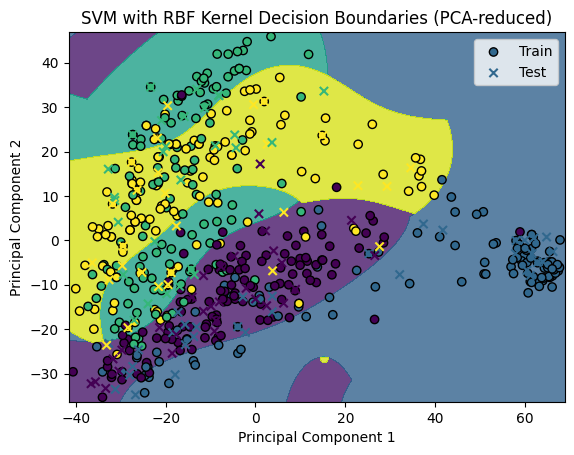

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from PIL import Image
import cv2
from skimage.feature import hog
from glob import glob
import gc

# Standardize the dataset
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Apply PCA to reduce the features to 2D for visualization
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

# Creating and training the SVC model
svc = SVC(kernel='rbf', C=100, gamma='scale', verbose=True, random_state=42)
svc.fit(x_train_pca, y_train)

# Predict and evaluate the model
y_pred = svc.predict(x_test_pca)
accuracy = accuracy_score(y_pred, y_test)
print("Accuracy score of the model is:", round(accuracy * 100, 2), "%")

# Create a mesh to plot the decision boundaries
h = .02  # step size in the mesh
x_min, x_max = x_train_pca[:, 0].min() - 1, x_train_pca[:, 0].max() + 1
y_min, y_max = x_train_pca[:, 1].min() - 1, x_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict classifications for each point in the mesh
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, alpha=0.8)

# Plot the training points with labels
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', label='Train')
#plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_test, edgecolors='k', marker='x', label='Test')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM with RBF Kernel Decision Boundaries (PCA-reduced)')
plt.legend()
plt.show()

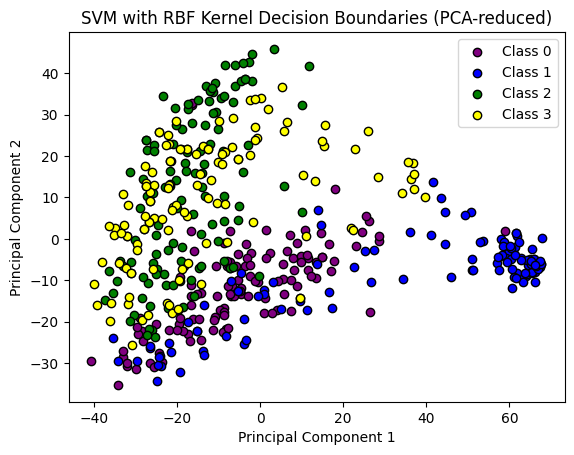

In [73]:
# Plot the training points with labels
colors = ['purple', 'blue', 'green', 'yellow']
for i in range(4):
    plt.scatter(x_train_pca[y_train == i, 0], x_train_pca[y_train == i, 1],
                label=f'Class {i}', edgecolors='k', marker='o', color=colors[i])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('SVM with RBF Kernel Decision Boundaries (PCA-reduced)')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.5, 1],
    'kernel': ['rbf', 'linear', "poly"],
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(x_train, y_train)

print("Best parameters found: ", grid.best_params_)
y_pred = grid.predict(x_test)
print("Accuracy score after GridSearchCV: ", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   1.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.7s
[CV] END ....................C=0.1, gamma=scale

In [ ]:
from sklearn.svm import SVC

svc = SVC(C=1, gamma= "scale", kernel="poly", random_state=42)
svc.fit(x_train,y_train)

SVC(C=1, kernel='poly', random_state=42)

In [ ]:
y_pred = svc.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))

Accuracy score of model is  94.17


In [ ]:
model_filename = 'svm_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(svc, file)

In [ ]:
img = np.asarray(PIL.Image.open(notify_paths[100]))
img_gray = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
image, viz = hog(img_gray,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2), visualize=True)

x_tst = np.asarray(image)
pred = svc.predict([x_tst])
print(pred[0])

3


In [ ]:
# testing
def test_prediction(img_path, true_label, svc):
    img = np.asarray(PIL.Image.open(img_path))
    img_gray = cv2.cvtColor(cv2.resize(img,(96,64)),cv2.COLOR_RGB2GRAY)
    image, viz = hog(img_gray,orientations=9,pixels_per_cell=(16,16),
              cells_per_block=(2,2), visualize=True)

    x_tst = np.asarray(image)
    pred = svc.predict([x_tst])

    print("True label: ", true_label)
    plt.imshow(img)
    if pred[0] == 0.0:
        print("Prediction: Not a traffic sign")

    elif pred[0] == 1.0:
        print("Prediction: Danger signs")

    elif pred[0] == 2.0:
        print("Prediction: Prohibition signs")

    elif pred[0] == 3.0:
        print("Prediction: Announcement sign")


True label:  Not signs
Prediction: Not a traffic sign


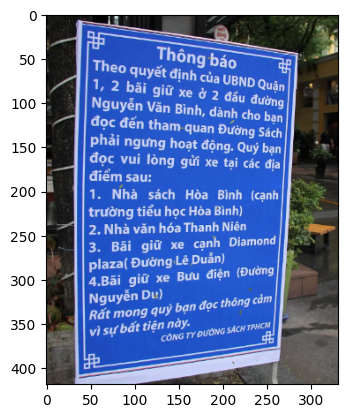

In [ ]:
test_prediction(neg_paths[69], "Not signs", svc)

True label:  Danger
Prediction: Danger signs


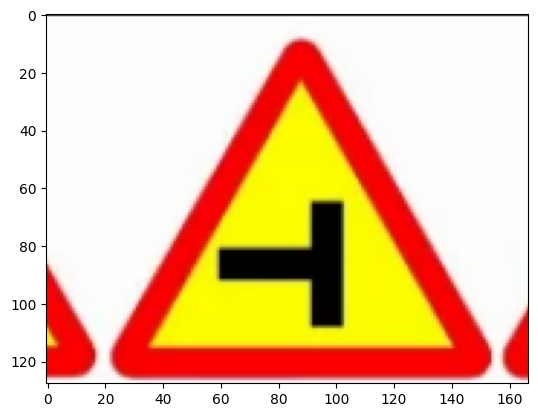

In [ ]:
test_prediction(danger_paths[20], "Danger", svc)

True label:  Prohibition
Prediction: Prohibition signs


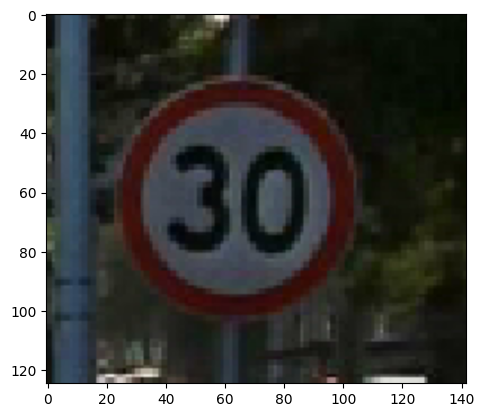

In [ ]:
test_prediction(prohi_paths[11], "Prohibition", svc)

True label:  Prohibition
Prediction: Not a traffic sign


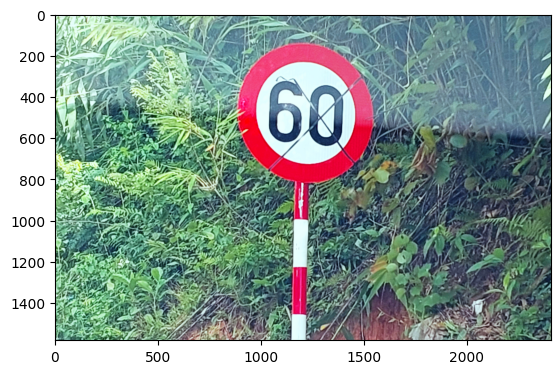

In [ ]:
test_prediction("/content/drive/MyDrive/FinalProject_CS231/data/test/01.jpg", "Prohibition", svc)

## Testing for different values of Regularization

In [ ]:
# testing
def test_prediction(img_path, true_label, svc):
    img = np.asarray(PIL.Image.open(img_path))
    img_gray = cv2.cvtColor(cv2.resize(img,(128,128)),cv2.COLOR_RGB2GRAY)
    image, viz = hog(img_gray,orientations=9,pixels_per_cell=(8,8),
              cells_per_block=(2,2), visualize=True)

    x_tst = np.asarray(image)
    pred = svc.predict([x_tst])

    print("True label: ", true_label)
    plt.imshow(img)
    if pred[0] == 0:
        print("Prediction: Not a traffic sign")

    elif pred[0] == 1:
        print("Prediction: Danger signs")

    elif pred[0] == 2:
        print("Prediction: Prohibition signs")

    elif pred[0] == 3:
        print("Prediction: Announcement sign")


True label:  Not traffic sign
Prediction: Not a traffic sign


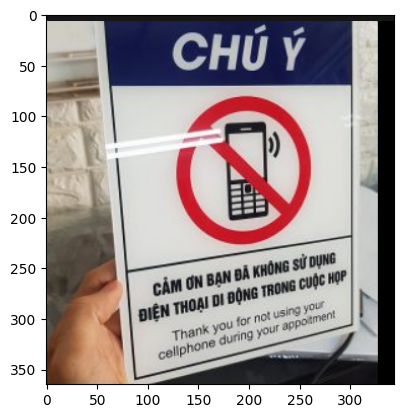

In [ ]:
test_prediction(neg_paths[-1], "Not traffic sign", svc)

True label:  Not traffic sign
Prediction: Not a traffic sign


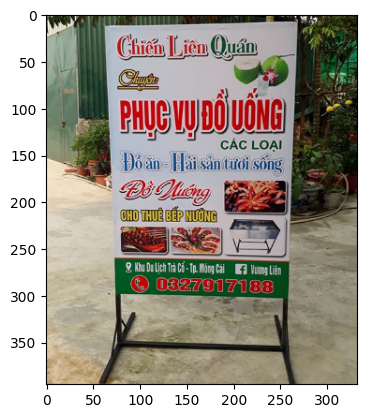

In [ ]:
test_prediction(neg_paths[-20], "Not traffic sign", svc)

# END.
